# MOPS for KBmod

Based off the CNN developed for the first ML search of the New Horizons 2020 search


In [1]:
import os, glob, sys
import time

import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv3D, Conv2D, MaxPool3D, MaxPool2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.visualization import interval

from trippy import tzscale
from trippy.trippy_utils import expand2d, downSample2d

from convenience_utils import calc_ecliptic_angle

from utils import shuffle

from ensemble import convnet_model

In [2]:

image_data_type = 'float32'

batch_size = 4096 # production used 128
dropout_rate = 0.2
test_fraction = 0.05
select_bad_at_random = True
badGoodRatio = 0.8*2.0#1.5
bad_edge_enhancement = 0.002

number_models = 5

useMedForNans = False #otherwise zero is used
useZscale = False


shuffle_augment = True # shuffle bootstrapping augmentation
double_flip = True # mirror vertically and horizontally augmentation
add_noise = False
noise_level=3.0


#good ranges [19,21.5], [21, 23.5] [23.5,25.5], [25.5, 26.8]
nukeBright = 26.0 # if set to a real value, all fainter planted source associations will be set to false
nukeFaint = 26.8 # if set to a real value, all fainter planted source associations will be set to false
dist_lim = 3.0 #association to planted source
save_model_iteration = False

useSampleWeights = True

useTripletGrids = True



"""These are some of the flags."""
visits = ['03072', '03093']

chips = []
#for i in range(103,-1,-1):
for i in range(104):
    if i==9: continue
    if i in [89]: continue
    chips.append(str(i).zfill(3))
#chips = ['031','050']
    


# Data Exploration

First read in the data, and make it look like the data from the tutorial



In [3]:

# load the data
#sns_frames = []
n_edge_added = 0
n_bad_total = 0

reference_fits_images = []
ecl_angles = []
stamp_files = []
kb_xys,fs = [],[]
for i, c in enumerate(chips):
    for j, v in enumerate(visits[:1]):
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])
        ecl_ang = calc_ecliptic_angle(reference_fits_images[-1])
        ecl_angles.append(ecl_ang)
        if c=='050':
            ref_ecl_ang = ecl_ang
            print(ref_ecl_ang)
ecl_angles = np.array(ecl_angles)
rots = (ref_ecl_ang-ecl_angles)*180./np.pi
print(len(rots))
corners = np.array([-270., -180., -90., 0., 90., 180., 270.])
for i,r in enumerate(rots):
    rot = corners[np.argmin(np.abs(r-corners))]
    if rot<0: 
        rot+=360.
    print(chips[i%len(chips)],r,rot)
    rots[i] = rot/90.
rots = rots.astype(np.int)


1.4412754795592164
102
000 -1.18808801867614 0.0
001 -0.09453831954545558 0.0
002 0.8744980819135028 0.0
003 1.8220850830578461 0.0
004 -2.1419920431726283 0.0
005 -1.0281424405745374 0.0
006 -0.16998761512827165 0.0
007 0.6729133575735556 0.0
008 1.3647796264404044 0.0
010 -1.7521249006635788 0.0
011 -0.8132820671602755 0.0
012 -0.18030994509453574 0.0
013 0.4196113635608986 0.0
014 1.0565958106580668 0.0
015 1.6194045314479253 0.0
016 178.5708055381495 180.0
017 179.28830235636485 180.0
018 179.833517837324 180.0
019 0.3175541021766452 0.0
020 0.7313349596999847 0.0
021 1.2064609133897453 0.0
022 178.10522623289881 180.0
023 178.93396660255365 180.0
024 179.45976272045675 180.0
025 179.86591912393425 180.0
026 0.1805464075787674 0.0
027 0.49840039885517345 0.0
028 0.7765309092959752 0.0
029 1.0202150843358275 0.0
030 178.62038902387246 180.0
031 179.17062636917515 180.0
032 179.59403802004894 180.0
033 179.90643617324594 180.0
034 0.0799578687083001 0.0
035 0.23008868736247362 0.0
03

In [4]:
gridType = ''
if useTripletGrids:
    gridType = '_tg'
    
counter = 0
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        stamps_path = f'/media/fraserw/rocketdata/Projects/kbmod/stamps/{v}'
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_files.append(f'{stamps_path}/stamps{gridType}_{c}.pickle')

        
        ### get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        ### load the kbmod results
        kb_xy = []
        if os.path.isfile(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper_0/results_MERGED.txt'):
            #check if the kbmod results from CANFAR are available
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper_0/results_MERGED.txt') as han:
                data = han.readlines()
        else:
            ### otherwise open a local copy
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_lower/results_LOWER.txt') as han:
                data = han.readlines()
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper/results_UPPER.txt') as han:
                data += han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        if v == '03072':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_May25-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0218606-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03093':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_June19-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0220262-{c}.plantList') as han:
                data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            ra,dec = float(s[1]), float(s[2])
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                args = np.argsort(d)

                if d[args[0]]<dist_lim:
                    kb_xy[args[0],-1] = p_xy[ii,2]
                    #print(kb_xy[args[0]])
            #print(p_xy[np.where(p_xy[:,2]>=nukeFaint)])
                    
        w_bad = np.where(kb_xy[:,-1]==0)
        w_good = np.where(kb_xy[:,-1]>0)
        print(v, c, len(w_bad[0]), len(w_good[0]), len(kb_xy))

        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)
        
        ### trim to just the best cutout
        f = f[:,5,:,:]
        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
            
        n_good = len(w_good[0])
        
        n_bad_keep = max(1, int(n_good*badGoodRatio))
        if n_bad_keep>0:
            if not select_bad_at_random:
                # sequential selection
                step = int(len(w[0])/n_bad_keep)
                w = w_bad[0][np.arange(0,len(w_bad[0]),step)]
            else:
                # random selection
                w = w_bad[0][(np.random.rand(n_bad_keep)*len(w_bad[0])).astype(np.int)]

        ### add edge bad sources
        if bad_edge_enhancement>0:
            NN = 0
            w_edge = np.where((kb_xy[:, -1] ==0) & ((kb_xy[:,0]<25) | ((B-kb_xy[:,0])<20) | (kb_xy[:, 1]<25) | ((A-kb_xy[:,1])<20)))
            n_edge_bad_keep = int(len(w_edge[0])*bad_edge_enhancement)
            while NN<n_edge_bad_keep:
                j = int(np.random.rand(1)*len(w_edge[0]))
                if j not in w:
                    w = np.append(w, j)
                    NN += 1
        n_edge_added+=NN
        n_bad_total += len(w)
        
        w = np.concatenate([w, w_good[0]])
        
        
        print('Number good, bad, and number edge enhanced:', n_good, n_bad_keep, n_edge_bad_keep)

        f = f[w]
        kb_xy = kb_xy[w]

        ### rotate frames
        # k should be -rots!
        if rots[counter%len(chips)]!=0:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1
        
        
        fs.append(f)
        kb_xys.append(kb_xy)
        del f, kb_xy

        


source_details = np.concatenate(kb_xys)
sns_frames = np.concatenate(fs)
print(sns_frames.shape)
del kb_xys
del fs
    
print('Number of bad edge sources added:',n_edge_added)
print(f'Number of total bad sources in sample {n_bad_total}')

03072 000 2497 7 2504
Number good, bad, and number edge enhanced: 7 11 0
03093 000 2614 3 2617
Number good, bad, and number edge enhanced: 3 4 0
03072 001 3642 3 3645
Number good, bad, and number edge enhanced: 3 4 0
03093 001 4363 1 4364
Number good, bad, and number edge enhanced: 1 1 0
03072 002 3471 1 3472
Number good, bad, and number edge enhanced: 1 1 0
03093 002 4264 4 4268
Number good, bad, and number edge enhanced: 4 6 0
03072 003 4064 4 4068
Number good, bad, and number edge enhanced: 4 6 0
03093 003 4033 6 4039
Number good, bad, and number edge enhanced: 6 9 0
03072 004 2157 1 2158
Number good, bad, and number edge enhanced: 1 1 0
03093 004 2997 4 3001
Number good, bad, and number edge enhanced: 4 6 0
03072 005 3331 2 3333
Number good, bad, and number edge enhanced: 2 3 0
03093 005 3668 6 3674
Number good, bad, and number edge enhanced: 6 9 0
03072 006 3478 4 3482
Number good, bad, and number edge enhanced: 4 6 0
03093 006 3911 5 3916
Number good, bad, and number edge enhance

Number good, bad, and number edge enhanced: 3 4 0
03093 058 3797 7 3804
Number good, bad, and number edge enhanced: 7 11 0
03072 059 1860 4 1864
Number good, bad, and number edge enhanced: 4 6 0
03093 059 3042 1 3043
Number good, bad, and number edge enhanced: 1 1 0
03072 060 2063 5 2068
Number good, bad, and number edge enhanced: 5 8 0
03093 060 4301 10 4311
Number good, bad, and number edge enhanced: 10 16 0
03072 061 1360 2 1362
Number good, bad, and number edge enhanced: 2 3 0
03093 061 4629 6 4635
Number good, bad, and number edge enhanced: 6 9 0
03072 062 1744 1 1745
Number good, bad, and number edge enhanced: 1 1 0
03093 062 3848 3 3851
Number good, bad, and number edge enhanced: 3 4 0
03072 063 2366 4 2370
Number good, bad, and number edge enhanced: 4 6 0
03093 063 3850 2 3852
Number good, bad, and number edge enhanced: 2 3 0
03072 064 2083 3 2086
Number good, bad, and number edge enhanced: 3 4 0
03093 064 3901 7 3908
Number good, bad, and number edge enhanced: 7 11 0
03072 065

In [5]:
print(np.min(sns_frames), np.max(sns_frames))

-1112.5203 2980.7305


In [6]:

# categorize the sources.
# column 0 is bad source. Labelled when ==1
# column 1 is good source
sns_labels = np.zeros((source_details[:, 5].shape[0], 2), dtype=image_data_type)
w = np.where(source_details[:, -1]==0)
W = np.where((source_details[:, -1]>0))
print('Number of planted sources in the dataset:', len(W[0]))
sns_labels[w, 0] = 1.0
sns_labels[W, 1] = 1.0


if useMedForNans:
    med = np.nanmedian(sns_frames)
else:
    med = 0.0
    
w_nan = np.where(np.isnan(sns_frames))
sns_frames[w_nan] = med

(z1, z2) = tzscale.zscale(sns_frames)
normer = interval.ManualInterval(z1,z2)

mean = np.nanmean(sns_frames)
std = np.nanstd(sns_frames)
print(mean, std)

sns_frames -= mean
sns_frames /= std
print('Normalized frame min and max:', np.nanmin(sns_frames), np.nanmax(sns_frames))



# expand the image data to shape (:, :, :, 1) for the CNN
#sns_frames = np.expand_dims(sns_frames, axis=3)
sns_frames = np.expand_dims(sns_frames, axis=3)
print(sns_frames.shape)


Number of planted sources in the dataset: 895
2.4397674 37.712738
Normalized frame min and max: -29.564548 78.97307
(2255, 21, 21, 1)


In [7]:
if shuffle_augment:
    a = np.copy(sns_frames)
    b = np.copy(sns_frames)
    c = np.copy(sns_frames)
    d = np.copy(sns_frames)
    a[:,:-1,:,:] = sns_frames[:,1:,:,:]
    b[:,1:,:,:] = sns_frames[:,:-1,:,:]
    c[:,:, :-1,:] = sns_frames[:,:,1:,:]
    d[:,:, 1:,:] = sns_frames[:,:,:-1,:]
    sns_frames = np.concatenate([sns_frames,a,b,c,d])
    sns_labels = np.concatenate([sns_labels, np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels), np.copy(sns_labels)])
    source_details = np.concatenate([source_details, np.copy(source_details), np.copy(source_details), np.copy(source_details), np.copy(source_details)])


if double_flip:

    sns_frames = np.concatenate([sns_frames, sns_frames[:, ::-1, ::-1, :]])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    
    
if add_noise:
    noise = np.random.normal(0.0, noise_level, sns_frames.shape).astype(image_data_type)
    #noised_sns_frames = normed_sns_frames + np.random.normal(0.0, noise_level, normed_sns_frames.shape, dtype=image_data_type)
    sns_frames = np.concatenate([sns_frames, sns_frames+noise])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    #del noised_sns_frames
    del noise
    mean = np.mean(sns_frames)
    std = np.std(sns_frames)
    print(mean, std)

    sns_frames -= mean
    sns_frames /= std

In [8]:

print('Faintest source in dataset:', np.max(source_details[:, -1]))

Faintest source in dataset: 26.79


# Training and Test/Validation Samples

In this part we will split our sample into two; one sample that we will use to train the neural network, aptly named the training sample, and another sample called the test sample. The network will not see the test sample itself during training, but we will use the trained neural network to predict its labels. It will therefore serve as validation to the accuracy of the neural network that has been trained using a different subset of images. We chose to set the size of the test sample as 15% of the total sample, as it is common practice to choose a test sample smaller in size compared to the training sample. It is important to make this split by roughly preserving the ratio of the labels within the total sample. Random splits may cause one of the labels to be underrepresented within training sample, thereby resulting in a neural network inacapable of accurate classifications as it is undertrained in one of the labels. We perform a stratified sampling below to preserve the original ratios of the two morphology types when making the split. 

I have modified the following to work with my data arrays, not those from the tutorial

In [9]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples. We choose the test sample to be 15%
of the total sample size.
"""

skf = StratifiedShuffleSplit(n_splits=1, test_size=test_fraction, random_state=410)
print(skf)
skf.split(sns_frames, sns_labels)


for train_index, test_index in skf.split(sns_frames, sns_labels):
    X_train, X_test = sns_frames[train_index], sns_frames[test_index]
    y_train, y_test = sns_labels[train_index], sns_labels[test_index]

#del sns_frames


print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified as real in the training sample: ',
      len(np.unique(np.where(y_train == [0, 1])[0])))
print('Number of objects classified as false in the training sample: ',
      len(np.unique(np.where(y_train == [1, 0])[0])))
print()
print('Number of images in the test sample: ', X_test.shape[0])
print('Number of objects classified as real in the validation sample: ',
      len(np.unique(np.where(y_test == [0, 1])[0])))
print('Number of objects classified as false in the validation sample: ',
      len(np.unique(np.where(y_test == [1, 0])[0])))
print()
print('Fraction of bad objects in the training sample',
      round((np.count_nonzero(y_train == [1, 0])/2)/X_train.shape[0], 3))

move_real_to_test = False
# remove the real source from the training set as a test to see what happens
if args[0] in train_index and move_real_to_test:
    w = np.where(train_index == args[0])

    print(X_train[w[0], 0, 0, 0])
    print(y_train[w[0]])
    
    X_test = np.concatenate([X_test, X_train[w[0]]])
    y_test = np.concatenate([y_test, y_train[w[0]]])
    test_index = np.append(test_index, [args[0]], -1)
    
    X_train = np.concatenate([X_train[:w[0][0]], X_train[w[0][0]+1:]])
    y_train = np.concatenate([y_train[:w[0][0]], y_train[w[0][0]+1:]])
    train_index = np.concatenate([train_index[:w[0][0]], train_index[w[0][0]+1:]])
    print(X_train.shape)
    print(y_train.shape)
    print(train_index.shape)
    print(X_test.shape)
    print(X_train[w[0][0],0, 0, 0])
    print(y_train[w[0]])
    print()
    print(X_test[-1, 0, 0, 0])
#w = np.where(train_index == args[0])
#y_train[w[0]][0] = 0.0
#y_train[w[0]][0] = 1.0


StratifiedShuffleSplit(n_splits=1, random_state=410, test_size=0.05,
            train_size=None)
Number of images in the training sample:  21422
Number of objects classified as real in the training sample:  8502
Number of objects classified as false in the training sample:  12920

Number of images in the test sample:  1128
Number of objects classified as real in the validation sample:  448
Number of objects classified as false in the validation sample:  680

Fraction of bad objects in the training sample 0.603


In [10]:
if useSampleWeights:
    n_false_total = len(np.where(y_train[:,0]==1)[0]) + len(np.where(y_test[:,0]==1)[0])
    n_true_total = len(np.where(y_train[:,1]==1)[0]) + len(np.where(y_test[:,1]==1)[0])
    print('Fraction of good to bad sources:',n_true_total/n_false_total)
    
    true_weight = 1.0
    nominal_false_weight = 0.83
    false_weight = n_true_total*nominal_false_weight/n_false_total
    print('False weight:' , false_weight)
    
    train_weight = np.ones(y_train.shape[0], dtype = y_train.dtype)
    train_weight[np.where(y_train[:,0]==1)] = false_weight
    train_weight[np.where(y_train[:,1]==1)] = true_weight
    test_weight = np.ones(y_test.shape[0], dtype = y_train.dtype)
    test_weight[np.where(y_test[:,0]==1)] = false_weight
    test_weight[np.where(y_test[:,1]==1)] = true_weight

        

Fraction of good to bad sources: 0.6580882352941176
False weight: 0.5462132352941177


# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

Ensemble of 5, each with the follwing configuration:

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 21, 21, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 16)        160       
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
max_poo

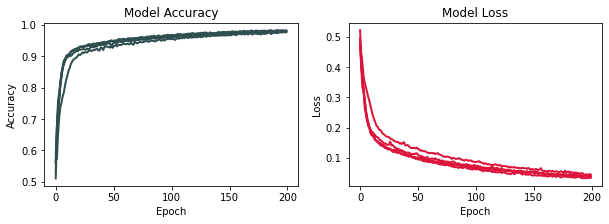

In [11]:
cn_model = convnet_model(X_train.shape[1:], num_models = number_models, dropout_rate = dropout_rate)
cn_model.compile(verbose = 1)
cn_model.summary()

epochs=100
if nukeBright==26:
    epochs = 200
cn_model.train_models_with_one_trainset(X_train, y_train,
                                        sample_weights = train_weight,
                                        batch_size = batch_size, 
                                        train_epochs = epochs,
                                        verbose = 0)



fig = pyl.figure(figsize=(10,3))

ax1 = pyl.subplot(121)
for k in range(number_models):
    ax1.plot(cn_model.classifiers[k].history['accuracy'], color='darkslategray', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = pyl.subplot(122)
for k in range(number_models):
    ax2.plot(cn_model.classifiers[k].history['loss'], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

pyl.show()
pyl.close()

# Save the Model

In [12]:
saveModel = True
if saveModel:
    cn_model.saveModel(mean,std,save_dir=f'ML_KBmod_modelSave_{nukeBright}_{nukeFaint}_01, random_split_seed=410)
    print('saved')


SyntaxError: EOL while scanning string literal (<ipython-input-12-291695e8add2>, line 3)

# Validation

Finally, we use the model trained above to make predictions on the test/validation sample. We then compare these predicted labels with the original ones, and derive a prediction accuracy. 

In [ ]:
preds_test = cn_model.predict(X_test, verbose=1)

preds_train = cn_model.predict(X_train, verbose=1)




In [ ]:

pyl.figure(figsize=(10,10))
pyl.hist(preds_train[:, 1], bins=200, density=True,alpha=0.5, label='Train', log=True)
pyl.hist(preds_test[:, 1], bins=200, density=True,alpha=0.5,label='Test', log=True)
pyl.legend()
pyl.show()

In [ ]:

def Eff(m,  eff_max=0.8295, c=0.0054, M_0=26.3803,sig= 0.2016  ):
    return (eff_max-c*(m-21.0)**2)/(1+np.exp((m-M_0)/sig))

# measure the distribution of p values as a function of magnitude
eff_fig = pyl.figure('Efficiency Estimate', figsize=(12, 8))
eff_sp = eff_fig.add_subplot(111)
eff_sp.set_xlabel('r')
eff_sp.set_ylabel('e(r)')
                  
figure = pyl.figure('P-value histogram', figsize=(12, 12))
sp = figure.add_subplot(111)

# 0.998 I get 3/36
good_p_value = 0.9
m_step = 0.25

print(len(np.where(preds_test>good_p_value)[0]))

bins = np.linspace(0.0,1.0,10000)
n_false = bins*0.0
n_found = 0.0
K = np.sum(np.less(bins,good_p_value))
n_bin_diff = 0
for m in np.arange(19.,28.,m_step):
    # plot the P-value cumulative distributions
    w = np.where( ((source_details[test_index, 5]-m)>=0) & ((source_details[test_index, 5]-m)<=m_step) )
    p_values = preds_test[w[0],1]
    
    n = bins*0.0
    k = ((p_values-bins[0])/(bins[1]-bins[0])).astype(np.int)
    for i in k:
        n[i:]+=1.0
    n_found+=n[-1]-n[K]
    n/=n[-1]
    
    
    # plot the efficiency curve estimate
    
    sp.plot(bins,n,label=f'{m}<=r<={m+m_step}')
    eff_sp.scatter(m+m_step/2.,1.0-n[K])
    if len(p_values)>0:
        print('{:.2f} {:.4f} {:.4f} {:.2f} {}'.format( m, np.min(p_values), np.max(p_values), 1.0-n[K], n_found-n_bin_diff ))
    n_bin_diff = n_found
    
eff_sp.plot(np.arange(19.,28.,m_step/10.),Eff(np.arange(19.,28.,m_step/10.)))

# now sum up the false positives
w = np.where( (source_details[test_index, 5])==0) 
p_values_false = preds_test[w[0],1]

k = ((p_values_false-bins[0])/(bins[1]-bins[0])).astype(np.int)
for i in k:
    n_false[:i]+=1.0

print()
print(f'Number of false-marked candidates with P>{good_p_value}:',np.sum(n_false[K:]))
print(f'Number of sources marked as real with P>{good_p_value}:',n_found)

n_false/=n_false[0]
pyl.plot(bins, n_false,'k:', lw=4)

eff_sp.grid()
    
pyl.plot([0, 1], [0.1, 0.1], 'k--')
pyl.plot([0, 1], [0.3, 0.3], 'k--')
pyl.plot([0, 1], [0.5, 0.5], 'k--')
pyl.plot([0, 1], [0.7, 0.7], 'k--')
pyl.plot([good_p_value, good_p_value], [0, 1], 'k:')
sp.legend()
sp.set_yscale('log')
sp.set_xlim(0.99,1.0)
pyl.xlabel('P(is real)')
pyl.ylabel('N(p<P)')
pyl.show()

In [ ]:

counter = 0

for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        stamps_path = f'/media/fraserw/rocketdata/Projects/kbmod/stamps/{v}'
        warps_path = f'/media/fraserw/SecondStage/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_file = f'{stamps_path}/stamps{gridType}_{c}.pickle'

        
        ### get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        ### load the kbmod results
        kb_xy = []
        if os.path.isfile(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper_0/results_MERGED.txt'):
            #check if the kbmod results from CANFAR are available
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper_0/results_MERGED.txt') as han:
                data = han.readlines()
        else:
            ### otherwise open a local copy
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_lower/results_LOWER.txt') as han:
                data = han.readlines()
            with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper/results_UPPER.txt') as han:
                data += han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0, 0.0])
        kb_xy = np.array(kb_xy)
        
        ### load the plantlist sources
        p_xy = []
        if v == '03072':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_May25-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0218606-{c}.plantList') as han:
                data = han.readlines()
        elif v == '03093':
            with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_June19-lsst/rerun/processCcdOutputs/{v}/HSC-R2/corr/planted/CORR-0220262-{c}.plantList') as han:
                data = han.readlines()
                
        for ii in range(1,len(data)):
            s = data[ii].split()
            ra,dec = float(s[1]), float(s[2])
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where((p_xy[:,2]>nukeBright)&(p_xy[:,2]<nukeFaint))]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                args = np.argsort(d)

                if d[args[0]]<dist_lim:
                    kb_xy[args[0],-2] = p_xy[ii,2]
                    #print(kb_xy[args[0]])
            #print(p_xy[np.where(p_xy[:,2]>=nukeFaint)])
         
        ### rotate frames
        # k should be -rots!
        if rots[counter%len(chips)]!=0:
            f = np.rot90(f, k=-rots[counter%len(chips)], axes=(1, 2))
        counter+=1
        
        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)
        
        ### trim to just the best cutout
        f = f[:,5,:,:]
        ### clip to avoid the crazy min pixel values
        f = np.clip(f, -3500., np.max(f))
        
        f -= mean
        f /= std

        # expand the image data to shape (:, :, :, 1) for the CNN
        #sns_frames = np.expand_dims(sns_frames, axis=3)
        f = np.expand_dims(f, axis=3)
        preds = cn_model.predict(f, verbose=1)

        w = np.where(preds[:, 1]>good_p_value)
        print(len(w[0]), len(f))
        #for k in w[0]:
        #    kb_xy[k,-1]=1.0
        #    print(kb_xy[k])
        break
    break
        